# Seattle AirBnB Exploration

In this notebook I explored the Seattle AirBNB Data from Kaggle [dataset](https://www.kaggle.com/airbnb/seattle). I followed the [**CRISP-DM**](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) process for this project. 


For **Business Understanding**, I would like to better understand the Seattle Airbnb rental price and the feature engagement of the price. In order to achieve this goal I asked three business questions:

- Does Seattle Airbnb price depend on seasons or days? 
- What are the most important features for the price? 
- For those features what insight can be delivered so the price can be guided in the future? 

For **Data Understanding**, I collected three tables from the Seattle Airbnb dataset. I focused on the first and second ones. The first table **calendar.csv** lists price as a function of listing_id and date, with totally 1.4 million data points. The second table **listings.csv** is the major one I looked into. There are 91 fields plue one price column with 3818 data points from the table, I plan to understand the relation between the 91 fields and the price. 

For **Data Preparation**, it is straightforward to use the calendar table to explore the price distribution and study the seasonality variation. Feature engineering needs to be carried out for the listings table. I removed the categorical fields which has only one values or too many values (> 1500), and converted some categorical values to numbers such as weekly_price, monthly_price, cleaning_fee, security_deposit, etc. Then the categorical fields were encoded. There are many missing values, some of which were replaced by zero and others were replaced by the mean of the fields, depending on which methods make more sense. More feature engineering work see below and in my blog. 

For **Data Modeling**, I built a price predictor based on the features in the listing table, deployed LightGBM and Random Forest regressors to train the data so I could rank the importance of features related to price prediction, and select the most important features to explore the insights from them.  

For **Evaluation**, I used R-square, MSE and MAE to estimate the model accuracy. Then I analyzed the most important features and delivered the insight to guide customers to better understand the price, so people can get the best rates. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
ls Seattle-data

calendar.csv  listings.csv  reviews.csv


In [3]:
# read the calendar data

df_calen = pd.read_csv('Seattle-data/calendar.csv')
print(df_calen.shape)

df_calen.head(10)

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [4]:
# read the listings data

pd.set_option('display.max_columns', None)

df_list = pd.read_csv('Seattle-data/listings.csv')
df_list_origin = df_list
print(df_list.shape)

df_list.head()

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [5]:
# Read the review data

df_reviews = pd.read_csv('Seattle-data/reviews.csv')
print(df_reviews.shape)

df_reviews.head()

(84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Exploratory Data Analysis

In [6]:
df_calen.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [7]:
# missing values are the same as available = "f" cases

df_calen.price.isnull().sum()

459028

In [8]:
# select only "t"

df_calen = df_calen[df_calen.available == 't']

In [9]:
# how many ids?

len(df_calen.listing_id.unique())

3723

In [10]:
# convert price from strings to floats

df_calen['price'] = df_calen.price.apply(lambda x: float(x[1:].replace(',', '')))

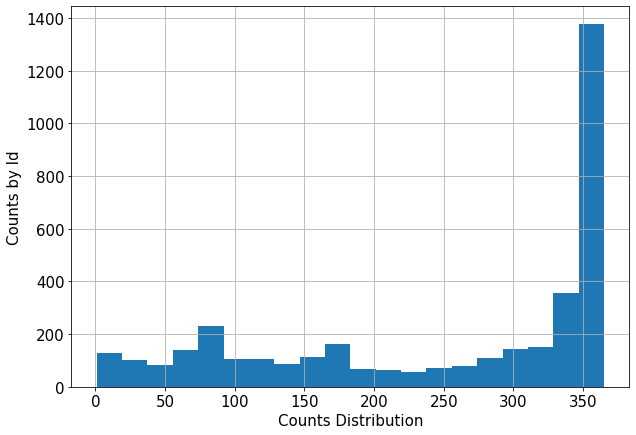

In [11]:
# How many counts for each id

fig = plt.subplots(figsize=(10, 7))
df_calen.groupby('listing_id')['price'].count().hist(bins=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Counts Distribution', fontsize=15)
plt.ylabel('Counts by Id', fontsize=15)
plt.show()

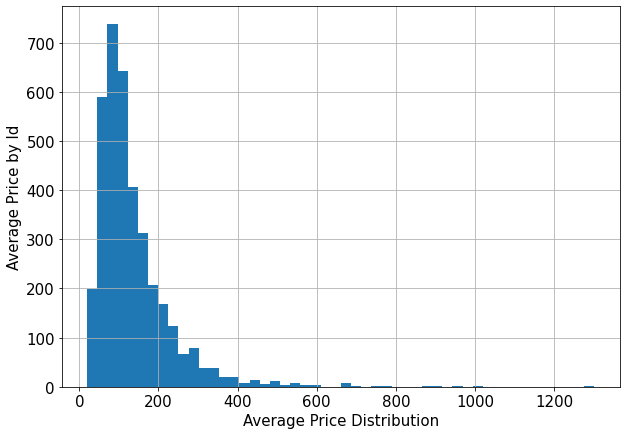

In [12]:
# The Price distribution. The price is averaged by each listing_id. 

fig = plt.subplots(figsize=(10, 7))
df_calen.groupby('listing_id')['price'].mean().hist(bins=50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Average Price Distribution', fontsize=15)
plt.ylabel('Average Price by Id', fontsize=15)
plt.show()

In [13]:
# mean of the above figure

df_calen.groupby('listing_id')['price'].mean().mean()

135.7640601537379

In [14]:
# most of the data was from the yeaar 2016

pd.to_datetime(df_calen.date).dt.year.value_counts()

2016    928844
2017      5698
Name: date, dtype: int64

In [15]:
df_calen['month'] = pd.to_datetime(df_calen.date).dt.month
df_calen['weekday'] = pd.to_datetime(df_calen.date).dt.day_name()

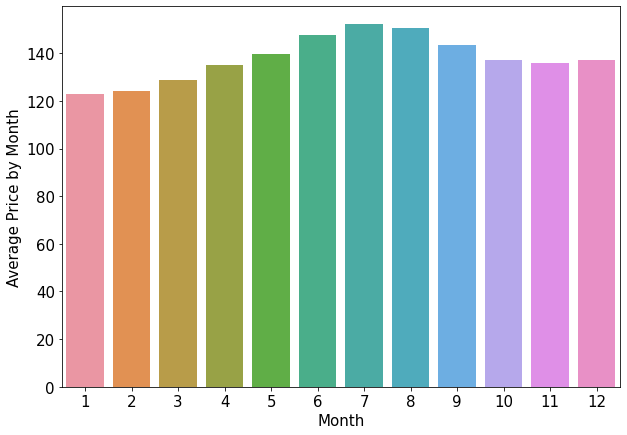

In [16]:
# See the relation of price and month, seasonal variation

fig = plt.subplots(figsize=(10, 7))
df_month = df_calen.groupby('month')['price'].mean().reset_index()
sns.barplot(x = 'month', y = 'price', data = df_month)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Average Price by Month', fontsize=15)
plt.show()

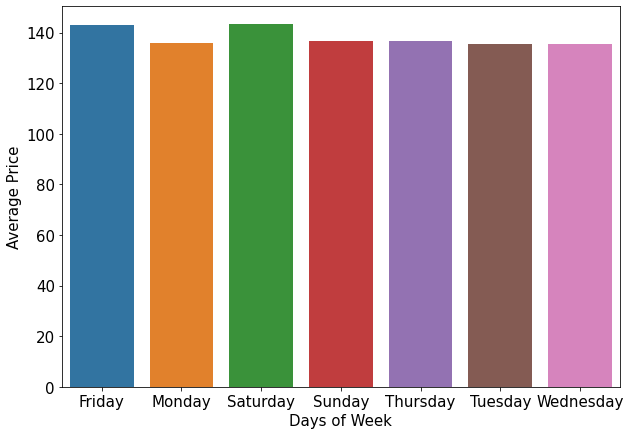

In [17]:
# See the relation of price and days of the week

fig = plt.subplots(figsize=(10, 7))
df_weekday = df_calen.groupby('weekday')['price'].mean().reset_index()
sns.barplot(x = 'weekday', y = 'price', data = df_weekday)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Days of Week', fontsize=15)
plt.ylabel('Average Price', fontsize=15)
plt.show()

## Modeling: Build a Price Predictor

In [18]:
# check missing values in listing
# Remove fields with missing values > 80 percent

def missing_analysis(df):
    
    """
    Description: This function is to check missing values for all features in the dataframe df.
    
    Arguments: 
    df: the pandas dataframe
    
    Returns:
    df_missing: a dataframe with three columns: fields/features, missing values and missing rates
    drop_columns: features with missing values more than 80 percent
    
    """
    
    fields = list(df.columns)
    missing = list(df.isnull().sum())

    df_missing = pd.DataFrame({'field':fields, "missing":missing}).sort_values('missing',ascending=False)
    df_missing['rate'] = df_missing.missing/df.shape[0]

    drop_columns = list(df_missing[df_missing.rate > 0.8].field)

    return df_missing, drop_columns

In [19]:
df_missing, drop_columns = missing_analysis(df_list)
drop_columns

['license', 'square_feet']

In [20]:
df_list = df_list.drop(drop_columns, axis=1)

In [21]:
# Check column dtypes

df_list.dtypes.value_counts()

object     62
float64    15
int64      13
dtype: int64

In [22]:
# Look at categorical features

cate_list = list(df_list.select_dtypes('object').columns)
length_list = []


for cate in cate_list:
    
    length_list.append(len(df_list[cate].unique()))
    
df_cate = pd.DataFrame({'category': cate_list, 'values': length_list}).sort_values('values',ascending=False)
df_cate.head(10).reset_index(drop=True)

,category,values
0,listing_url,3818
1,picture_url,3818
2,name,3792
3,description,3742
4,thumbnail_url,3499
5,xl_picture_url,3499
6,medium_url,3499
7,summary,3479
8,amenities,3284
9,space,3120


In [23]:
# drop categorical fields which have more than 1500 values

cate_drop_list = df_cate.category[(df_cate['values'] > 1500) | (df_cate['values'] == 1)].values
df_cate = df_cate[(df_cate['values'] < 1500) & (df_cate['values'] > 1)]
#df_cate
df_list[df_cate.category.values].head()

,host_name,street,host_since,first_review,weekly_price,monthly_price,last_review,price,host_location,cleaning_fee,host_verifications,host_neighbourhood,neighbourhood_cleansed,neighbourhood,security_deposit,host_response_rate,extra_people,calendar_updated,zipcode,neighbourhood_group_cleansed,property_type,city,smart_location,host_response_time,bed_type,host_has_profile_pic,cancellation_policy,host_acceptance_rate,host_is_superhost,host_identity_verified,room_type,is_location_exact,instant_bookable,state,require_guest_profile_picture,require_guest_phone_verification
0,Maija,"Gilman Dr W, Seattle, WA 98119, United States",2011-08-11,2011-11-01,NaN,NaN,2016-01-02,$85.00,"Seattle, Washington, United States",NaN,"['email', 'phone', 'reviews', 'kba']",Queen Anne,West Queen Anne,Queen Anne,NaN,96%,$5.00,4 weeks ago,98119,Queen Anne,Apartment,Seattle,"Seattle, WA",within a few hours,Real Bed,t,moderate,100%,f,t,Entire home/apt,t,f,WA,f,f
1,Andrea,"7th Avenue West, Seattle, WA 98119, United States",2013-02-21,2013-08-19,"$1,000.00","$3,000.00",2015-12-29,$150.00,"Seattle, Washington, United States",$40.00,"['email', 'phone', 'facebook', 'linkedin', 're...",Queen Anne,West Queen Anne,Queen Anne,$100.00,98%,$0.00,today,98119,Queen Anne,Apartment,Seattle,"Seattle, WA",within an hour,Real Bed,t,strict,100%,t,t,Entire home/apt,t,f,WA,t,t
2,Jill,"West Lee Street, Seattle, WA 98119, United States",2014-06-12,2014-07-30,NaN,NaN,2015-09-03,$975.00,"Seattle, Washington, United States",$300.00,"['email', 'phone', 'google', 'reviews', 'jumio']",Queen Anne,West Queen Anne,Queen Anne,"$1,000.00",67%,$25.00,5 weeks ago,98119,Queen Anne,House,Seattle,"Seattle, WA",within a few hours,Real Bed,t,strict,100%,f,t,Entire home/apt,t,f,WA,f,f
3,Emily,"8th Avenue West, Seattle, WA 98119, United States",2013-11-06,NaN,$650.00,"$2,300.00",NaN,$100.00,"Seattle, Washington, United States",NaN,"['email', 'phone', 'facebook', 'reviews', 'jum...",Queen Anne,West Queen Anne,Queen Anne,NaN,NaN,$0.00,6 months ago,98119,Queen Anne,Apartment,Seattle,"Seattle, WA",NaN,Real Bed,t,flexible,NaN,f,t,Entire home/apt,t,f,WA,f,f
4,Emily,"14th Ave W, Seattle, WA 98119, United States",2011-11-29,2012-07-10,NaN,NaN,2015-10-24,$450.00,"Seattle, Washington, United States",$125.00,"['email', 'phone', 'facebook', 'reviews', 'kba']",Queen Anne,West Queen Anne,Queen Anne,$700.00,100%,$15.00,7 weeks ago,98119,Queen Anne,House,Seattle,"Seattle, WA",within an hour,Real Bed,t,strict,NaN,f,t,Entire home/apt,t,f,WA,f,f


In [24]:
cate_drop_list

array(['listing_url', 'picture_url', 'name', 'description',
       'thumbnail_url', 'xl_picture_url', 'medium_url', 'summary',
       'amenities', 'space', 'host_url', 'host_picture_url',
       'host_thumbnail_url', 'transit', 'neighborhood_overview',
       'host_about', 'notes', 'last_scraped', 'country', 'country_code',
       'has_availability', 'calendar_last_scraped', 'market',
       'experiences_offered', 'requires_license', 'jurisdiction_names'],
      dtype=object)

In [25]:
cate_drop_list2 = \
['host_since','last_review','calendar_updated','host_acceptance_rate']

df_list = df_list.drop(cate_drop_list, axis=1)
df_list = df_list.drop(cate_drop_list2, axis=1)

In [26]:
# convert weekly_price to float
df_list.weekly_price = df_list.weekly_price.fillna(0)
df_list.weekly_price = df_list.weekly_price.apply(lambda x: x if x==0 else float(x[1:].replace(',', '')))

# convert monthly_price to float
df_list.monthly_price = df_list.monthly_price.fillna(0)
df_list.monthly_price = df_list.monthly_price.apply(lambda x: x if x==0 else float(x[1:].replace(',', '')))

# convert price to float
df_list.price = df_list.price.apply(lambda x: float(x[1:].replace(',', '')))


# convert cleaning_fee
df_list.cleaning_fee = df_list.cleaning_fee.fillna(0)
df_list.cleaning_fee = df_list.cleaning_fee.apply(lambda x: x if x==0 else float(x[1:].replace(',', '')))

# convert security_deposit
df_list.security_deposit = df_list.security_deposit.fillna(0)
df_list.security_deposit = df_list.security_deposit.apply(lambda x: x if x==0 else float(x[1:].replace(',', '')))

# convert extra_people
df_list.extra_people = df_list.extra_people.fillna(0)
df_list.extra_people = df_list.extra_people.apply(lambda x: x if x==0 else float(x[1:].replace(',', '')))

# convert host_response_rate
df_list.host_response_rate = df_list.host_response_rate.fillna(0)
df_list.host_response_rate = df_list.host_response_rate.apply(lambda x: x if x==0 else float(x[:-1].replace(',', '')))

mean0 = df_list.host_response_rate[df_list.host_response_rate !=0].mean()
df_list.host_response_rate = df_list.host_response_rate.apply(lambda x: mean0 if x==0 else x)

In [27]:
# Encode categorical list

cate_list = list(df_list.select_dtypes('object').columns)

Label = LabelEncoder()

for cate in cate_list:    
    Label.fit(df_list[cate].astype(str))
    df_list[cate] = Label.transform(df_list[cate].astype(str))

In [28]:
# Remove features which only have one value

drop_list3 = []

for column in df_list.columns:
    if len(df_list[column].unique()) == 1:
        drop_list3.append(column)
        
df_list = df_list.drop(drop_list3, axis=1)

In [29]:
# Check correlation with Price

corrs = df_list.corr()
corrs = corrs.sort_values('price', ascending = False)
corrs['price']

price                               1.000000
accommodates                        0.652218
bedrooms                            0.627720
beds                                0.589525
cleaning_fee                        0.576423
bathrooms                           0.516424
weekly_price                        0.394486
guests_included                     0.392875
security_deposit                    0.333579
monthly_price                       0.275787
cancellation_policy                 0.209361
extra_people                        0.127961
bed_type                            0.115261
host_listings_count                 0.093962
host_total_listings_count           0.093962
review_scores_location              0.075069
require_guest_profile_picture       0.063297
require_guest_phone_verification    0.057599
review_scores_rating                0.055551
review_scores_cleanliness           0.054357
property_type                       0.044799
review_scores_accuracy              0.019026
minimum_ni

In [30]:
corrs['price'].head(6)

price           1.000000
accommodates    0.652218
bedrooms        0.627720
beds            0.589525
cleaning_fee    0.576423
bathrooms       0.516424
Name: price, dtype: float64

In [31]:
corrs['price'].tail(6)

host_location        -0.069900
longitude            -0.102420
host_response_time   -0.116930
number_of_reviews    -0.124695
reviews_per_month    -0.218588
room_type            -0.430088
Name: price, dtype: float64

In [32]:
# Remove Collinear Variables

corrs = df_list.corr()
    
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:

    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

    # Track columns to remove and columns already examined

cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():

    #print(key,value)
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))
cols_to_remove_pair = list(set(cols_to_remove_pair))
print('Number of columns to remove pair: ', len(cols_to_remove_pair))

df_list = df_list.drop(columns = cols_to_remove)

Number of columns to remove:  8
Number of columns to remove pair:  8


In [33]:
# removed collinear variables

cols_to_remove

['neighbourhood',
 'availability_60',
 'beds',
 'smart_location',
 'first_review',
 'availability_90',
 'require_guest_phone_verification',
 'host_total_listings_count']

In [34]:
# Prepare Training and Testing data for pricce prediction

df_train = df_list.drop('price', axis=1)
y = df_list.price

feature_importance = pd.DataFrame()
feature_importance['feature'] = df_train.columns

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df_train)
df_train = imputer.transform(df_train)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df_train)
df_train = scaler.transform(df_train)

X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.2, random_state=42)

### LightGBM Regression

In [35]:
# LightGBM Regression

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=1000, verbose = 200)

Training until validation scores don't improve for 1000 rounds


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's l1: 34.3872	valid_0's l2: 3076.45	valid_0's auc: 1
[400]	valid_0's l1: 27.9118	valid_0's l2: 2180.12	valid_0's auc: 1
[600]	valid_0's l1: 26.3985	valid_0's l2: 1981.57	valid_0's auc: 1
[800]	valid_0's l1: 26.0225	valid_0's l2: 1916.02	valid_0's auc: 1
[1000]	valid_0's l1: 25.8584	valid_0's l2: 1892.6	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l1: 60.2804	valid_0's l2: 8064.03	valid_0's auc: 1


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.005, max_bin=512,
              max_depth=8, metric=['l2', 'auc'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_iterations=100000, num_leaves=128,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=0)

In [36]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE:", median_absolute_error(y_test, y_pred))

feature_importance['coeff_gbm'] = gbm.feature_importances_/gbm.feature_importances_.sum()
feature_importance.sort_values('coeff_gbm', ascending=False).head(20)

R2:  0.006440417516105912
MSE:  8064.0325266325535
MAE: 47.54296949488709


,feature,coeff_gbm
27,weekly_price,0.384615
49,reviews_per_month,0.076923
30,cleaning_fee,0.057692
14,neighbourhood_group_cleansed,0.057692
13,neighbourhood_cleansed,0.038462
35,availability_30,0.038462
24,bathrooms,0.038462
18,latitude,0.038462
25,bedrooms,0.038462
8,host_listings_count,0.038462


### Random Forest Regression

In [37]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE:", median_absolute_error(y_test, y_pred))

feature_importance['coeff_rf'] = rf.feature_importances_
feature_importance['coeff_mix'] = (feature_importance['coeff_gbm']+feature_importance['coeff_rf'])/2
feature_importance.sort_values('coeff_mix', ascending=False).head(20)

R2:  0.7286815627897687
MSE:  2202.1031665445025
MAE: 14.99300000000001


,feature,coeff_gbm,coeff_rf,coeff_mix
27,weekly_price,0.384615,0.149917,0.267266
25,bedrooms,0.038462,0.354484,0.196473
49,reviews_per_month,0.076923,0.030959,0.053941
24,bathrooms,0.038462,0.063755,0.051108
30,cleaning_fee,0.057692,0.027209,0.042451
22,room_type,0.019231,0.049422,0.034326
14,neighbourhood_group_cleansed,0.057692,0.005627,0.031660
23,accommodates,0.019231,0.041708,0.030469
18,latitude,0.038462,0.018581,0.028521
13,neighbourhood_cleansed,0.038462,0.015750,0.027106


In [38]:
# Average the feature importance estimate by lightGBM and Random Forest

feature_importance['coeff_rf'] = rf.feature_importances_
feature_importance['coeff_mix'] = (feature_importance['coeff_gbm']+feature_importance['coeff_rf'])/2
feature_importance.sort_values('coeff_mix', ascending=False).reset_index(drop=True).head(20)

,feature,coeff_gbm,coeff_rf,coeff_mix
0,weekly_price,0.384615,0.149917,0.267266
1,bedrooms,0.038462,0.354484,0.196473
2,reviews_per_month,0.076923,0.030959,0.053941
3,bathrooms,0.038462,0.063755,0.051108
4,cleaning_fee,0.057692,0.027209,0.042451
5,room_type,0.019231,0.049422,0.034326
6,neighbourhood_group_cleansed,0.057692,0.005627,0.031660
7,accommodates,0.019231,0.041708,0.030469
8,latitude,0.038462,0.018581,0.028521
9,neighbourhood_cleansed,0.038462,0.015750,0.027106


In [39]:
def plot_feature_importances(df, top_N):
    
    """
    Description: 
    This function is to visualize the top N important features with their normalized importance
    
    Arguments:
    df: the dataframe with all features ranked by normalized importance
    top_N: input the number N for selecting top N features
    
    Return:
    None
    
    """
    
    #Sort features according to importance
    df = df.sort_values('coeff_mix', ascending = False).reset_index()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (12, 10))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:top_N]))), 
            df['coeff_mix'].head(top_N), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:top_N]))))
    ax.set_yticklabels(df['feature'].head(top_N))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Plot labeling
    plt.xlabel('Feature Importance', fontsize=15)
    plt.title('Feature Importances', fontsize=15)
    plt.show()
    
    #return df

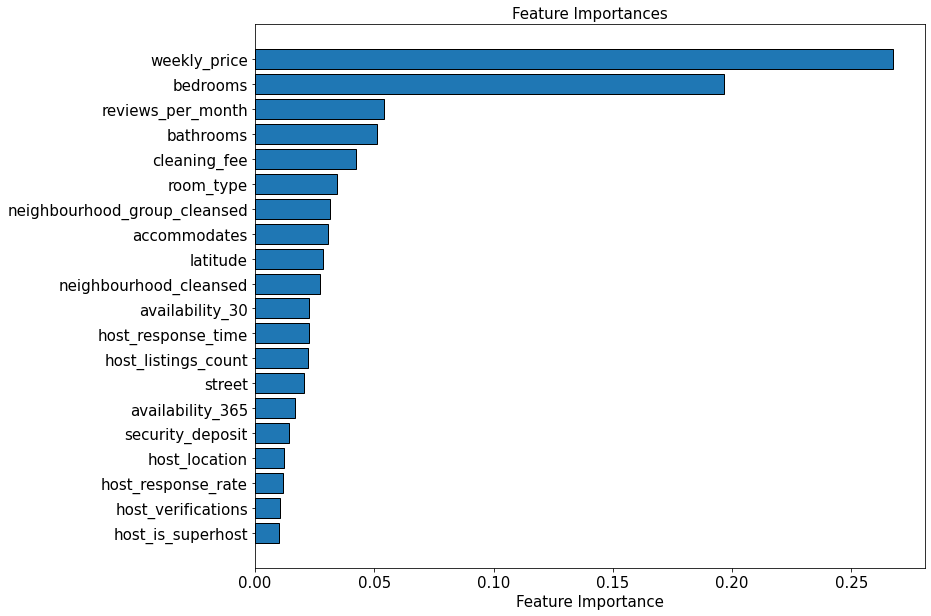

In [40]:
# Visualize the feature importance

plot_feature_importances(feature_importance, top_N=20)

## Analyze Importance Features

In [41]:
df_list_origin['price'] = df_list['price']

In [42]:
def group_result(feature, label, df_list):
    
    """
    Description: Count and average the price by a certain feature
    
    Arguments:
    feature: the certain feature for the label to group by
    label: for this special function the labeled data is the price
    df_list: the original dataframe
    
    Return:
    The final result/dataframe with the price count and mean for each value of the feature
    
    """
    
    df = df_list[[feature,label]].groupby(feature).count().reset_index()
    df = df.rename(columns = {label:'Counts'})
    df1 = df_list[[feature,label]].groupby(feature).mean().reset_index()
    df1 = df1.rename(columns = {label:'Mean'})

    df = df.merge(df1, on = feature, how='left').sort_values('Counts',ascending=False)
    
    return df

In [43]:
df_group = group_result('weekly_price', 'price', df_list)
df_group[df_group.weekly_price!=0]

,weekly_price,Counts,Mean
117,500.0,94,84.265957
159,600.0,85,99.258824
280,1000.0,70,158.000000
99,450.0,68,74.867647
199,700.0,62,111.838710
...,...,...,...
127,535.0,1,65.000000
125,528.0,1,88.000000
41,299.0,1,69.000000
123,524.0,1,85.000000


In [44]:
df_bedrooms = group_result('bedrooms', 'price', df_list)
df_bedrooms

,bedrooms,Counts,Mean
1,1.0,2417,95.706247
2,2.0,640,174.062500
0,0.0,372,103.548387
3,3.0,283,249.530035
4,4.0,69,313.695652
5,5.0,24,441.000000
6,6.0,6,578.166667
7,7.0,1,375.000000


In [45]:
def linear_plot_feature(df, color):
    
    """
    Description: visualize the relation between the price mean and the feature values
    
    Arguments:
    df: the imported dataframe for visualization
    color: what is the color for the data points
    """
    
    fig = plt.subplots(figsize=(10, 8))
    
    feature = df.columns[0]
    #color = 'blue'

    x = df[df[feature]!=0][feature]
    y = df[df[feature]!=0].Mean
    
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    
    plt.scatter(x, y, c=color, s = 100)
    plt.plot(x, poly1d_fn(x), ':')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Averaged Price', fontsize=15)
    plt.title(feature +' - Price Relation',  fontsize=15)

    plt.show()   

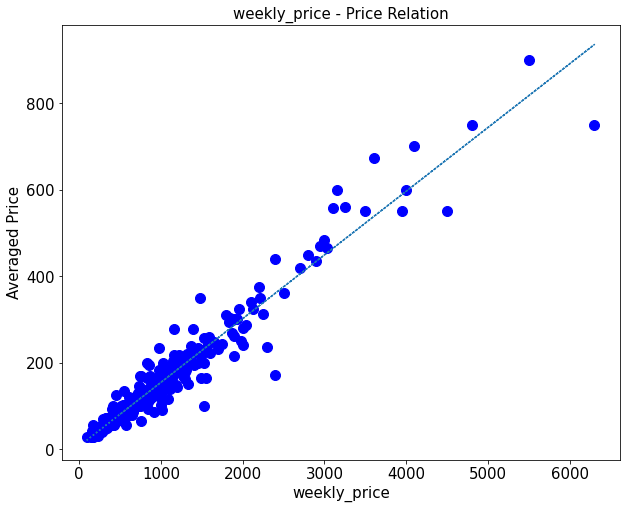

In [46]:
linear_plot_feature(df_group, 'blue')

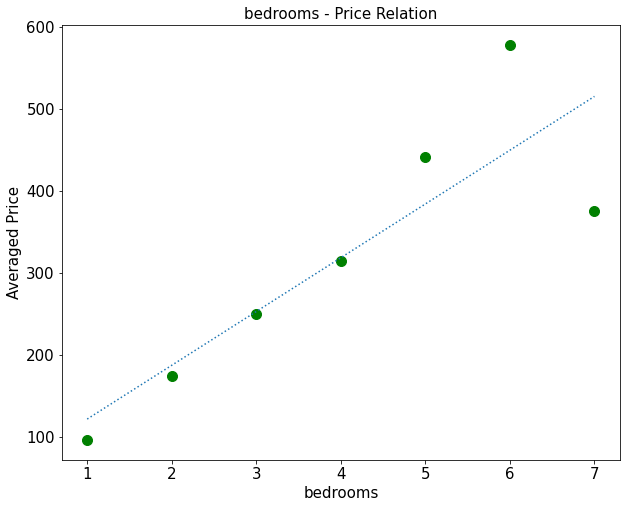

In [47]:
# Bedrooms

linear_plot_feature(df_bedrooms, 'g')

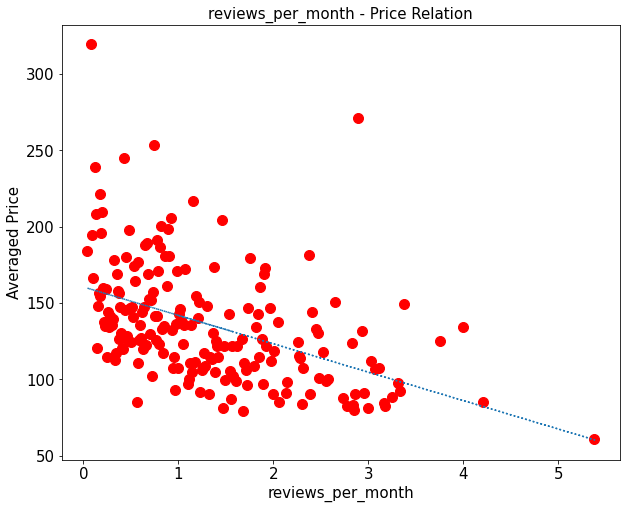

,reviews_per_month,Counts,Mean
98,1.00,70,107.428571
197,2.00,45,90.511111
21,0.23,24,135.083333
79,0.81,21,186.904762
14,0.16,21,156.714286
...,...,...,...
504,5.35,1,80.000000
505,5.36,1,100.000000
509,5.43,1,150.000000
514,5.53,1,41.000000


In [48]:
# reviews_per_month

df_rpm = group_result('reviews_per_month', 'price', df_list_origin)
linear_plot_feature(df_rpm[df_rpm.Counts>5], color = 'r')
df_rpm

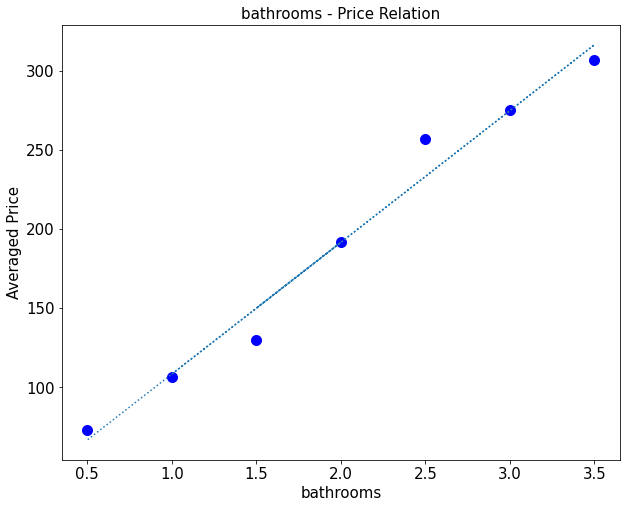

In [49]:
# bathrooms

df_bath = group_result('bathrooms', 'price', df_list_origin)
linear_plot_feature(df_bath[df_bath.Counts > 10], color = 'b')

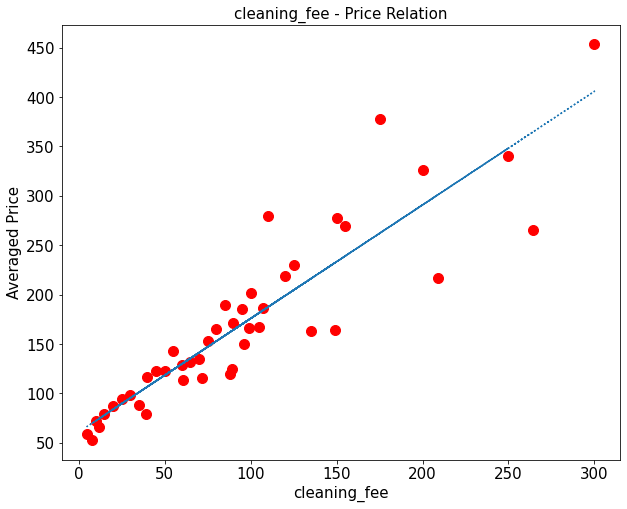

,cleaning_fee,Counts,Mean
0,0.0,1030,103.943689
32,50.0,310,122.374194
18,25.0,245,93.836735
37,60.0,185,129.016216
14,20.0,171,87.035088
...,...,...,...
85,142.0,1,158.000000
55,87.0,1,119.000000
35,58.0,1,105.000000
33,52.0,1,45.000000


In [50]:
# Cleaning Fee

df_cf = group_result('cleaning_fee', 'price', df_list)
linear_plot_feature(df_cf[(df_cf.Counts>5) & (df_cf.cleaning_fee !=0)], color = 'r')
df_cf

In [51]:
# Room types

df_rt = group_result('room_type', 'price', df_list_origin)
df_rt

,room_type,Counts,Mean
0,Entire home/apt,2541,155.843369
1,Private room,1160,75.044828
2,Shared room,117,47.547009


<ipython-input-52-8533e1f6b4ab>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


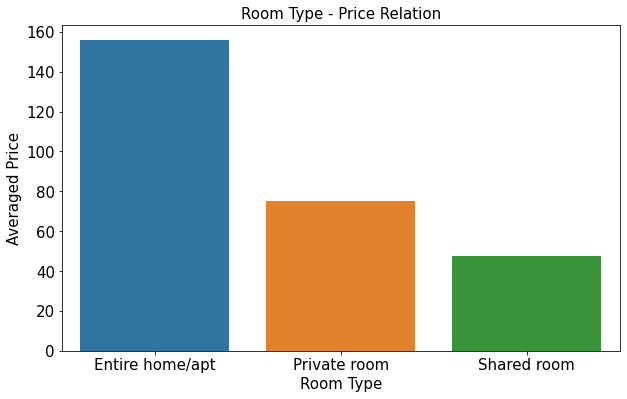

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='room_type', y = 'Mean',data=df_rt, ax=ax)
#plt.xticks(rotation=80)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Room Type', fontsize=15)
plt.ylabel('Averaged Price', fontsize=15)
plt.title('Room Type - Price Relation', fontsize=15)

fig.show()

In [53]:
# Look into neighbourhood_group_cleansed

df_neighb = group_result('neighbourhood_group_cleansed', 'price', df_list_origin)
df_neighb = df_neighb.sort_values('Mean',ascending=False)

<ipython-input-54-7bcfb4f5dbac>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


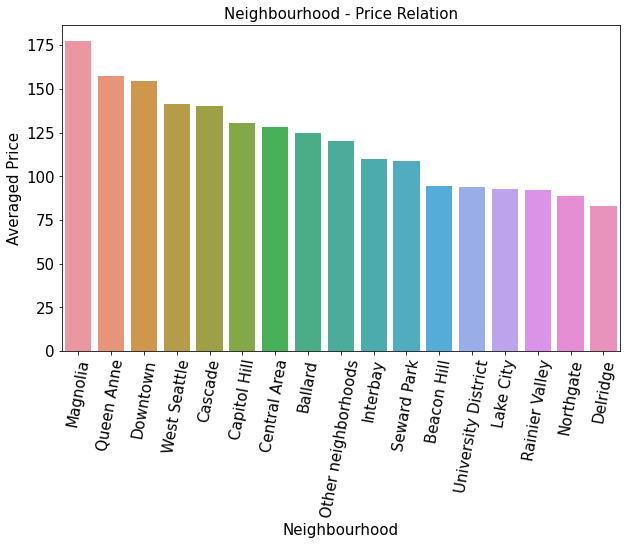

In [54]:
# Visualize the above df_neighb

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='neighbourhood_group_cleansed', y = 'Mean',data=df_neighb, ax=ax)
plt.xticks(rotation=80)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Neighbourhood', fontsize=15)
plt.ylabel('Averaged Price', fontsize=15)
plt.title('Neighbourhood - Price Relation', fontsize=15)

fig.show()